# Sequencer Fee Contributors

###  Draft RPGF3 List ✨

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "ProjectSequencerFees"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-01_SequencerFeeContributors.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list only considers projects with onchain activity on OP Mainnet."
                "The list identifies the total amount of sequencer fees generated by all of a project's",
                "smart contracts. It allocates a pool of tokens pro rata based on each project's",
                "sequencer fee contributions."
            ])
LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            #'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            #'OP_STACK'
            ]

AWARD_AMT = 1 * 10e6

JSON_PATH = DATA_DIR + "lists/" + LIST_NAME + ".json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
#oso.check_duplicate_slugs()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)
type_id = 26 # CONTRACT_INVOCATION_DAILY_FEES

query = f"""
    SELECT
        p.slug,
        sum(e.amount)
    FROM
        event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        p.slug IN ('{slugs_list}')
        AND e."typeId" = {type_id}
    GROUP BY
        p.slug;
"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

contributions = {project: round(amount / 10e17,4) for (project, amount) in results}
contributions

{'0x-splits': 0.0011,
 '1w3': 0.0,
 'across': 3.9706,
 'acrypto-s': 0.0004,
 'another-world': 0.0857,
 'anotherblock': 0.0003,
 'ape-framework': 0.0,
 'aw-labs': 0.0159,
 'chronicleprotocol': 0.0,
 'cliqueofficial': 0.0285,
 'coinpassport': 0.0,
 'coordinape': 0.4396,
 'crustio': 0.0,
 'dapp-learning-dao': 0.0007,
 'decent': 0.001,
 'decentragora': 0.0,
 'defi-llama': 0.2413,
 'delegatexyz': 0.0013,
 'dforce-network': 0.1681,
 'dm3-protocol': 0.0,
 'eco-association': 0.0006,
 'endaoment': 0.0,
 'eth-infinitism-account-abstraction': 13.8258,
 'ethereum-attestation-service': 0.4176,
 'filosofiacodigo': 0.0,
 'flipside-crypto': 0.0053,
 'galxe': 3.527,
 'gelato': 1.9608,
 'geo-web': 0.0029,
 'gitcoin': 1.1266,
 'gov-w3hc': 0.0,
 'grateful-protocol': 0.0018,
 'hats-protocol': 0.0757,
 'hausdao': 0.0,
 'hedgey-finance': 0.0027,
 'holograph': 0.2993,
 'holonym-foundation': 2.4769,
 'hop-protocol': 0.2692,
 'hypercerts': 0.4392,
 'idriss-crypto': 0.0035,
 'justcause-smeee23': 0.0035,
 'kiwi-n

# Generate the list

In [6]:
named_list = listify(contributions, AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

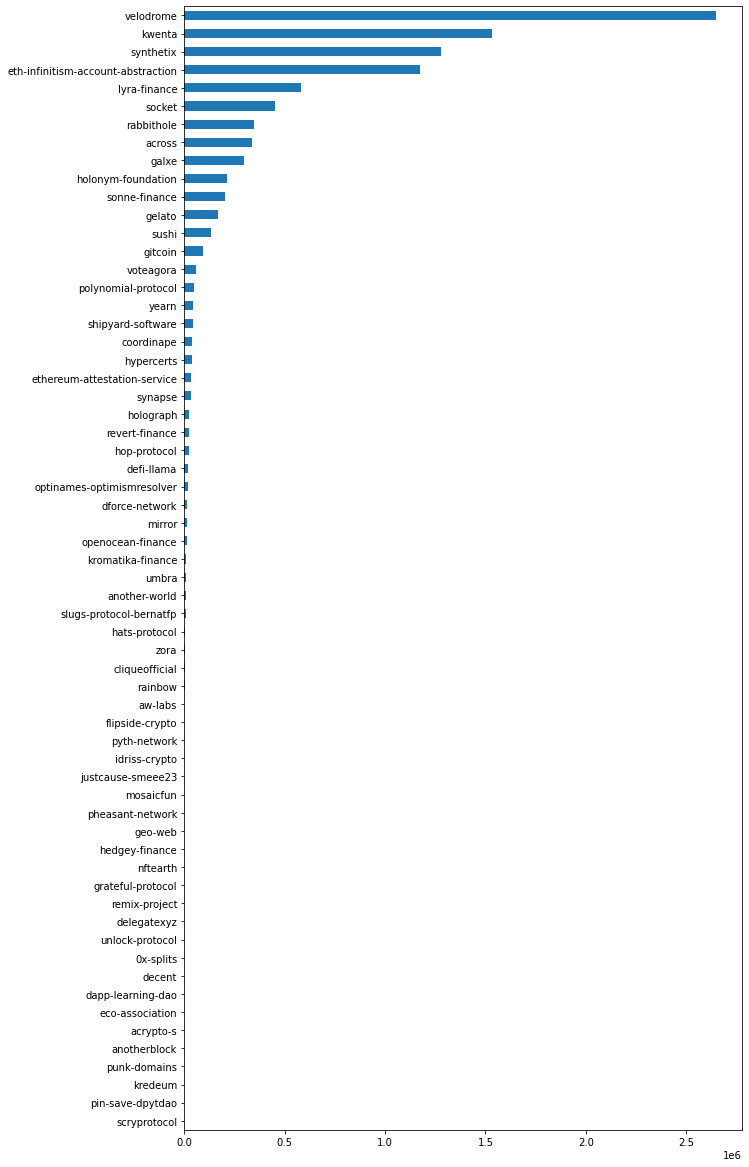

In [7]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)